# Probabilistic programming + functional programming



## (Lazy, strongly-typed) Functional programming

- purity: all functions are mathematical functions (no hidden side effects, no global state)
- static types: reason about the behavior of your program by looking at its type
- lazy evaluation
- compositionality: meaning of whole program should be a function of the meaning of the parts

In [1]:

:t True
:t not
:t (not True)
:t [True, False]
:t map
:t map not [True, False]

True :: Bool

not :: Bool -> Bool

(not True) :: Bool

[True, False] :: [Bool]

map :: forall {a} {b}. (a -> b) -> [a] -> [b]

map not [True, False] :: [Bool]

In [2]:
h :: [Int]
h = 1 : h

take 10 h

[1,1,1,1,1,1,1,1,1,1]

In [3]:
g :: [Int]
g = 1 : map (+1) g


take 10 g

[1,2,3,4,5,6,7,8,9,10]

In [4]:
isEven x = x `mod` 2 == 0
evens = take 10 . filter isEven

evens g

Line 1: Use even
Found:
x `mod` 2 == 0
Why not:
even x

[2,4,6,8,10,12,14,16,18,20]

In [5]:
sumOfEvens = foldr1 (+) . evens

sumOfEvens g

Line 1: Use sum
Found:
foldr1 (+)
Why not:
sum

110

## (Universal) probabilistic programming

- express probability distributions as programs
- separate model and inference
- programmable inference

In [126]:
:l Plotting.hs

: 

In [125]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase
:e RankNTypes

import Control.Arrow (first)
import Data.Text (pack)
import qualified Data.Text as T
import Control.Monad
import Numeric.Log
import Control.Monad.Loops

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator hiding (expectation)
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Integrator
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Free

import qualified Diagrams.Prelude as D
import Diagrams.Prelude (V2(..), (#))
import qualified Diagrams.Backend.Cairo as C

import Control.Monad.Bayes.Traced.Static

-- {-# LANGUAGE NoMonomorphismRestriction #-}
-- {-# LANGUAGE FlexibleContexts          #-}
-- {-# LANGUAGE TypeFamilies              #-}



type Distribution a = forall m . MonadSample m => m a
type Measure a = forall m . MonadInfer m => m a
type Real = Double

type Diagram = D.Diagram C.B
displayDiagram = diagram


: 


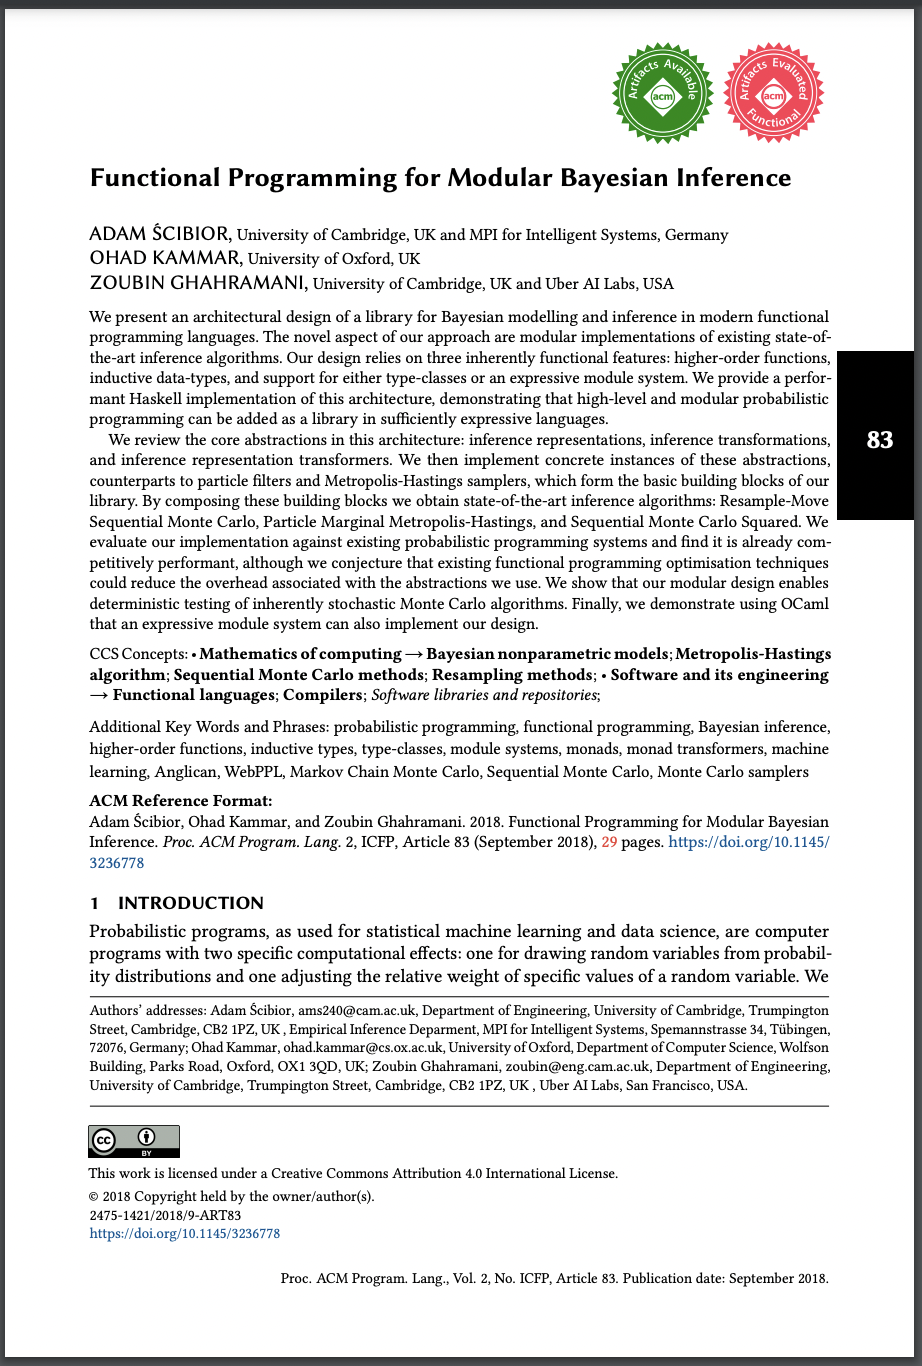

# An example of a distribution

In [108]:
model :: Distribution Real
model = do
    p <- bernoulli 0.2
    if p then normal 10 1 else normal (-5) 5

View this as an abstract description of a distribution. It is composed from simpler distributions, and can itself be a piece in larger distributions.

In [109]:
sampleIO model

-10.76617323092779

In [110]:
sampleIO $ runPopulation (spawn 10 >> model)

[(-8.102994230386564,9.999999999999998e-2),(1.3672413429129175,9.999999999999998e-2),(-8.492338887367554,9.999999999999998e-2),(-6.823179040605177,9.999999999999998e-2),(11.32016853790264,9.999999999999998e-2),(-7.636974023390758,9.999999999999998e-2),(-7.849571122160455,9.999999999999998e-2),(-3.2064389519149294,9.999999999999998e-2),(-4.398519087522298,9.999999999999998e-2),(-6.087146775031169,9.999999999999998e-2)]

In [111]:
sampleIO $ runWith [0.1, 0.2] model

(9.158378766427086,[0.1,0.2])

In [112]:
expectation model

-1.999999999999914

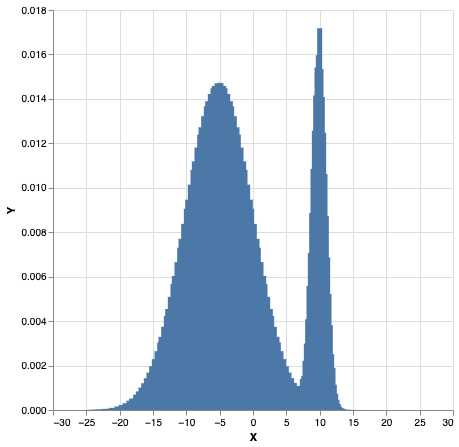

In [113]:
plotVega $ histogram 250 0.2 model

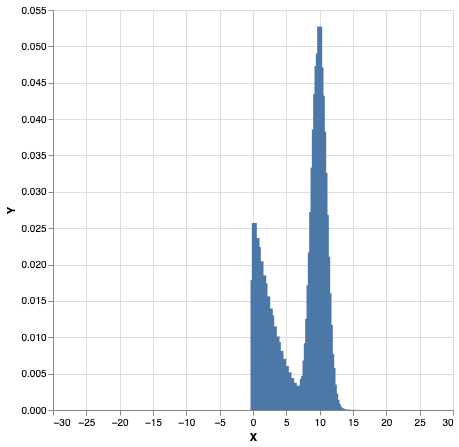

In [114]:
model2 :: Measure Real
model2 = do
    p <- bernoulli 0.2
    x <- if p then normal 10 1 else normal (-5) 5
    condition (x > 0)
    return x

plotVega $ histogram 250 0.2 model2

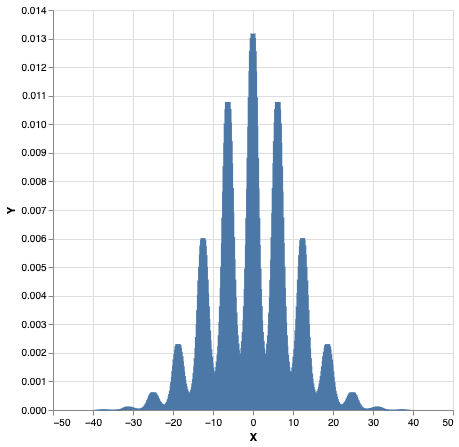

In [115]:
model3 :: Measure Double
model3 = do

    x <- normal 0 10
    factor $ Exp (cos x )
    return x

plotVega $ histogram 800 0.1 model3

# Compositionality

mapping
drawing

# Making use of laziness

We can use laziness to specify distributions over infinite lists (and other infinite structures) which we subsequently marginalize to finite distributions, but only as a final step.

In [116]:
import qualified Control.Monad.Bayes.Sampler.Lazy as L

infiniteList :: Distribution [Double]
infiniteList = do
    x <- random
    fmap (x :) infiniteList

finiteList :: Distribution [Double]
finiteList = fmap (take 4) infiniteList

L.sample finiteList


[0.45325569274220623,0.3461312428079897,0.1083192837461221,0.9372996376109263]

In [117]:
   interestingInfiniteList = do
    i1 <- infiniteList
    i2 <- tail <$> infiniteList
    return (zipWith (+) i1 i2)


L.sample (fmap (take 4) interestingInfiniteList)

[0.931749257048989,1.5310655021746626,1.1743680497413205,1.6085855617764047]

In [118]:


-- kernel :: MonadSample m => V2 Double -> Distribution (V2 Double)
kernel (V2 x y) = do
    newX <- normal x 0.01
    newY <- normal y 0.01
    return (V2 newX newY)

randomWalk :: Distribution [V2 Double]
randomWalk = unfoldrM (fmap (Just . (\x -> (x,x))) . kernel) 0


x <- L.sample randomWalk

take 4 x

[V2 (-4.3992043047237665e-3) (-5.208598030159332e-4),V2 (-2.1370349205815037e-3) (-1.4344534955151656e-2),V2 (-1.2613424631394608e-2) (-1.653567553014266e-2),V2 (-5.043527723798263e-3) (-3.976981928977938e-2)]

# Manipulating `randomWalk`

Given any function on lists of 2D vectors, we can use that function to transform `randomWalk`. As a neat example, let's introduce the type `Diagram` of diagrams, which are renderable and composable images:

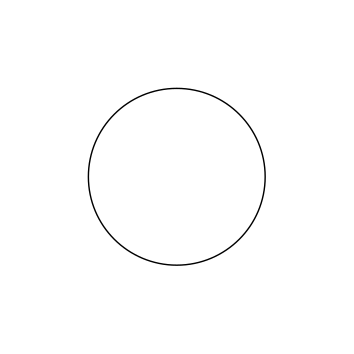

In [119]:
diagram $ D.circle 1 # D.frame 1

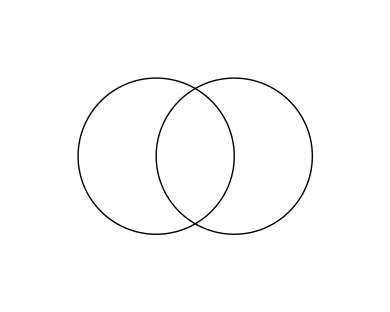

In [120]:
diagram $ (D.circle 1 <> D.circle 1 # D.translateX 1) # D.frame 1

# A distribution over diagrams

In [121]:
simpleDiagramDistribution :: Distribution Diagram
simpleDiagramDistribution = uniformD [D.circle 1, D.rect 1 1]

x <- sampleIO simpleDiagramDistribution
displayDiagram x

: 

# Transforming `randomWalk` into a distribution over diagrams

We can now create a more interesting distribution over diagrams, by transforming `randomWalk` 

In [122]:

convertPointToDiagram :: V2 Double -> Diagram
convertPointToDiagram point = circle 0.001 # translate point

convertListofNPointsToDiagram :: Int -> [V2 Double] -> Diagram
convertListofNPointsToDiagram n = mconcat . take n . fmap convertPointToDiagram

diagramList :: Distribution (Diagram)
diagramList = fmap (convertListofNPointsToDiagram 10000) randomWalk

d <- L.sample diagramList
displayDiagram d

: 

In [123]:
randomWalk2 = fmap (scanl (+) 0) randomWalk

d <- L.sample $ fmap (convertListofNPointsToDiagram 100) randomWalk2
displayDiagram d

: 

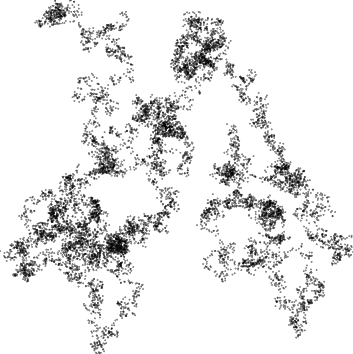

In [135]:
randomWalk3 = liftA2 (zipWith (+)) randomWalk (tail <$> randomWalk)

d <- L.sample $ fmap (convertListofNPointsToDiagram 10000) randomWalk3
displayDiagram d

-- calculate number of times we pass thru origin: expected position

## Applications of probabilistic programming to Bayesian statistics

An obvious application of probabilistic programming is to describe statistical models and perform Bayesian inference. Here are two typical cases.


### Regression



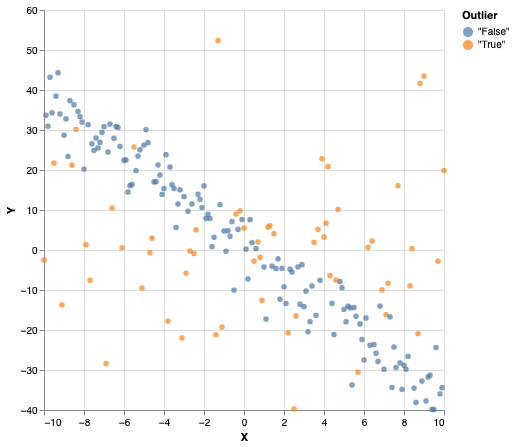

In [171]:
import Control.Arrow (second)
import Control.Monad.Bayes.Inference.PMMH

paramPrior = do
    slope <- normal 0 2
    intercept <- normal 0 2
    noise <- gamma 7 7
    prob_outlier <- uniform 0 0.5 
    return (slope, intercept, noise, prob_outlier)

forward (slope, intercept, noise, probOutlier) x = do
    isOutlier <- bernoulli probOutlier
    let meanParams = if isOutlier
                    then (0, 20)
                    else (x*slope + intercept, sqrt noise)
    return (meanParams, isOutlier)

regressionWithOutliersData :: (MonadSample m, Traversable t) => t Double -> m (t ((Double, Double), Bool))
regressionWithOutliersData xs = do
    params <- paramPrior

    forM xs \x -> do
        ((mu, std), isOutlier) <- forward params x
        y <- normal mu std
        return ((x, y), isOutlier)
        
range = [-10,-9.9..10] :: [Double]
samples <- sampleIOfixed $ regressionWithOutliersData range
plotVega (fmap (second (T.pack . show)) samples)


In [ ]:
regressionWithOutliers xs ys params = do
    
    outliers <- forM (zip xs ys) \(x, y) -> do
        ((mu, std), isOutlier) <- forward params x
        factor $ normalPdf mu std y
        return isOutlier
    return (params, outliers)

mhRuns <- sampleIOfixed $ prior $ pmmh 10 200 100
    paramPrior
    (regressionWithOutliers range (snd . fst <$> samples))

m = fmap (\((_,a), b) -> (a,b)) $ head mhRuns


outlierProb s = (\(x, y) ->   ln (exp (x / (x+y))) )
        <$> (foldr
    \(lb, d) li -> 
        [ if b then (num1+d, num2) else (num1,num2+d) | (b,(num1, num2)) <- zip lb li])
    (Prelude.repeat (0 :: Log Double,0 :: Log Double)) s

In [ ]:
plotVega $ take 1000 (zip (fst <$> samples) (outlierProb m))

As the above plot shows, this works nicely: the `slope`, `intercept`, `noise` and `prob_outlier` variables are inferred by a random walk through the space, while the score to determine whether to accept a new proposed step in this walk is determined by a particle filter which guesses which points are outliers after each observation.
